[![Otwórz w Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/12y34KRUHuGx947JFxv_65fTBXwv1KBL7#scrollTo=HnMAQlEvsP4u&uniqifier=1)

# Pneumonia detection

Currentlu working on versions: v0.2.0-alpha

## Introduction

Pneumonia is a common respiratory infection that affects millions of people worldwide, leading to significant morbidity and mortality. Accurate and timely diagnosis is essential for effective treatment and management of pneumonia. In recent years, deep learning techniques, particularly convolutional neural networks (CNNs), have shown great promise in medical image analysis, including the diagnosis of pneumonia through the analysis of chest X-ray images.

The goal of this project is to build a deep learning model to classify chest X-ray images into two categories: normal and pneumonia. We will use a dataset of chest X-ray images, preprocess the data, perform data augmentation, and train a convolutional neural network to classify the images. Finally, we will evaluate the model's performance on a test set and discuss the results. This project aims to demonstrate the potential of deep learning in medical image analysis and contribute to improving the diagnosis of pneumonia.




## Imports


In [1]:
# PyTorch modules
import torch
from torch import nn
import torchvision.models as models
from torch.utils.data import ConcatDataset, DataLoader, random_split

# Data splitting and shuffling modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import Subset

# Image processing modules
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

# File and directory handling modules
import os
from pathlib import Path
import shutil

# Progress bar and timing modules
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Other modules
import numpy as np
import requests
import zipfile
import random


## Loading and Preprocessing Data

### Load images from GitHub repository

In [2]:
# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'chest_xray'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else: 
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

# Download x-ray scans data
with open(data_path / 'chest_xray.zip', 'wb') as f:
  request = requests.get('https://github.com/eliaszpiotr/PneumoniaDetection/raw/main/data/chest_xray.zip')
  print('Downloading data...')
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / 'chest_xray.zip', 'r') as zip_ref:
  print('Unzipping data...')
  zip_ref.extractall(image_path)

data/chest_xray does not exist, creating one...
Unzipping data...


In [3]:
# Define paths to dataset folders
train_dir = image_path / 'chest_xray/train'
test_dir = image_path / 'chest_xray/test'
val_dir = image_path / 'chest_xray/val'

train_dir, test_dir, val_dir

(PosixPath('data/chest_xray/chest_xray/train'),
 PosixPath('data/chest_xray/chest_xray/test'),
 PosixPath('data/chest_xray/chest_xray/val'))

In [4]:
# Print out some info about data
print("Number of images in the training set:")
print("Pneumonia: ", len(os.listdir(train_dir / 'PNEUMONIA')))
print("Normal: ", len(os.listdir(train_dir / 'NORMAL')), '\n')

print("Number of images in the test set:")
print("Pneumonia: ", len(os.listdir(test_dir / 'PNEUMONIA')))
print("Normal: ", len(os.listdir(test_dir / 'NORMAL')), '\n')


print("Number of images in the validation set:")
print("Pneumonia: ", len(os.listdir(val_dir / 'PNEUMONIA')))
print("Normal: ", len(os.listdir(val_dir / 'NORMAL')), '\n')

Number of images in the training set:
Pneumonia:  3876
Normal:  1342 

Number of images in the test set:
Pneumonia:  390
Normal:  234 

Number of images in the validation set:
Pneumonia:  9
Normal:  9 



**Note:** Data is imbalanced, so we're gonna try to fix it by adding transformed samples.

### Data imbalance
To address data imbalance, we increased the number of samples and created a custom dataset by dividing the augmented images into subsets. This approach improved the balance of the dataset and contributed to better model performance.




#### Setup transformers
In order to mitigate the impact of an imbalanced dataset, I am implementing three transformers specifically designed for image processing. By employing three transformers, I aim to improve the performance and reliability of my models when dealing with the existing dataset limitations. This approach will enable me to gather stronger evidence and support for my arguments.


In [5]:
transformer = {
    'dataset1': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
        transforms.ToTensor(),
    ]),
    'dataset2': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=1),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(translate=(0.1, 0.05), degrees=10),
        transforms.ToTensor(),
    ]),
    'dataset3': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(translate=(0.08, 0.1), degrees=15),
        transforms.ToTensor(),
    ]),
}

In [6]:
# Setup paths
pneumonia_train_dir = train_dir / 'PNEUMONIA'
normal_train_dir = train_dir/ 'NORMAL'
pneumonia_test_dir = test_dir/ 'PNEUMONIA'
normal_test_dir = test_dir/ 'NORMAL'
pneumonia_val_dir = val_dir / 'PNEUMONIA'
normal_val_dir = val_dir/ 'NORMAL'

#### Creating helping functions


In [7]:
def apply_transforms(input_dir, transform, postfix):
    """
    Apply specified transformations to images in the input directory and save the transformed images to the same directory.

    Args:
        input_dir (str): Path to the directory containing the input images.
        transform (function): Transformation function to be applied to the images.
        postfix (str): String to append to the filename to indicate the transformation applied.

    Returns:
        None
    """
    # Only consider original images, not those that have been previously transformed
    img_list = [img for img in os.listdir(input_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')) and 'aug_' not in img]

    for i, img_name in enumerate(img_list):
        img_path = input_dir / img_name
        img = Image.open(img_path)
        transformed_img = transform(img)
        # Add the 'aug_' prefix to the filename to distinguish the augmented images from the original ones
        save_path = input_dir / f"aug_{postfix}_{img_name}"
        save_image(transformed_img, save_path)

    print(f"Saved {len(img_list)} transformed images to {input_dir}")



In [8]:
def select_and_save(input_dir, output_dir, num_images):
    """
    Randomly select the specified number of images from the given directory and save them to the output directory.

    Args:
        input_dir (str): Path to the directory containing the input images.
        output_dir (str): Path to the directory where the selected images will be saved.
        num_images (int): Number of images to select.

    Returns:
        None
    """
    img_list = [img for img in os.listdir(input_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]
    combined_list = [input_dir / img for img in img_list]

    selected_images = random.sample(combined_list, num_images)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for img_path in selected_images:
        shutil.copy(img_path, output_dir / img_path.name)

    print(f"Selected {len(os.listdir(output_dir))} images to {output_dir}")


#### Appling transformers and sampling images


In [9]:
# Set the desired number of images
DESIRED_IMAGES = 5000

# Create new directories for the selected data
selected_normal_dir = Path("selected_data/NORMAL")
selected_pneumonia_dir = Path("selected_data/PNEUMONIA")

# Apply transformations to all images and save them to the same directory
for transformer_name in ['dataset1', 'dataset2', 'dataset3']:
    apply_transforms(normal_train_dir, transformer[transformer_name], transformer_name)

# Select 5000 images from the combined original and transformed images and save them to the new directory
select_and_save(normal_train_dir, selected_normal_dir, DESIRED_IMAGES)

# Repeat the process for the pneumonia images
for transformer_name in ['dataset1', 'dataset2', 'dataset3']:
    apply_transforms(pneumonia_train_dir, transformer[transformer_name], transformer_name)

select_and_save(pneumonia_train_dir, selected_pneumonia_dir, DESIRED_IMAGES)


Saved 1341 transformed images to data/chest_xray/chest_xray/train/NORMAL
Saved 1341 transformed images to data/chest_xray/chest_xray/train/NORMAL
Saved 1341 transformed images to data/chest_xray/chest_xray/train/NORMAL
Selected 5000 images to selected_data/NORMAL
Saved 3875 transformed images to data/chest_xray/chest_xray/train/PNEUMONIA
Saved 3875 transformed images to data/chest_xray/chest_xray/train/PNEUMONIA
Saved 3875 transformed images to data/chest_xray/chest_xray/train/PNEUMONIA
Selected 5000 images to selected_data/PNEUMONIA


In [10]:
# Print out some info about data
print("Number of images in the training set:")
print("Pneumonia: ", len(os.listdir(selected_pneumonia_dir)))
print("Normal: ", len(os.listdir(selected_normal_dir)), '\n')

Number of images in the training set:
Pneumonia:  5000
Normal:  5000 



### Create Datasets

In [11]:
data_dir = '/content/selected_data'

In [12]:
# Setup datasets
train_dataset = ImageFolder(data_dir,transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
]))


In [13]:
all_indices = list(range(len(train_dataset)))
train_indices, temp_indices = train_test_split(
    all_indices,
    test_size=0.3, # 30% of the data will be used as temporary (validation + test)
    random_state=42,  # Set a random state to make the split deterministic
    stratify=train_dataset.targets
)

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,  # Half of the temporary data will be used as validation, and the other half as test
    random_state=42,
    stratify=[train_dataset.targets[i] for i in temp_indices]
)

full_dataset = ConcatDataset([train_dataset, Subset(train_dataset, temp_indices)])

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

In [14]:
len(train_dataset), len(test_dataset), len(val_dataset)


(7000, 1500, 1500)

In [15]:
# Get list of class names
class_names = full_dataset.datasets[0].classes
class_names

['NORMAL', 'PNEUMONIA']

### Create DataLoaders

In [16]:
# Set DataLoader parameters
batch_size = 32
num_workers = os.cpu_count()

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Data visualization

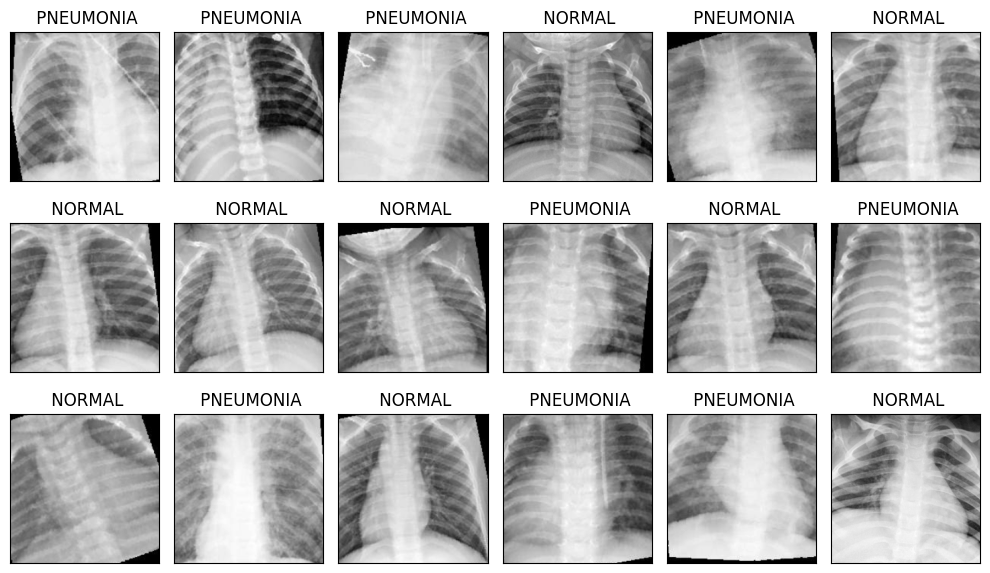

In [17]:
# Print sample images and labels from train_loader
for images, labels in train_loader:
    # Select the first batch from train_loader
    break

# Print out sample images
fig, axs = plt.subplots(3, 6, figsize=(10, 6), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i].squeeze().numpy(), cmap='gray')
    ax.set_title(f" {class_names[labels[i].item()]}")
plt.tight_layout()
plt.show()


## Define the Model

In [18]:
class PneumoniaClassifier(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        
        # First convolutional block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        # Second convolutional block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Avgpool layer
        self.avgpool = nn.AdaptiveAvgPool2d((13, 13))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        # Pass through the convolutional blocks
        x = self.conv_block_2(self.conv_block_1(x))
        
        # Avgpool layer
        x = self.avgpool(x)
        
        # Classification
        return self.classifier(x)

In [19]:
# Create a model instance
input_channels = 1  # image input channels (RGB) - 1 as we have images in gray scale
hidden_units = 10  # number of units hidden in convolutional layers
model = PneumoniaClassifier(input_channels, hidden_units, 2)

## Training Preparation

### Setting up device-agnostic code

In [20]:
# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Setting up loss function and optimizer

In [21]:
# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

## Training

In [22]:
# Setup random seed
torch.manual_seed(42)

# Measure time
start_time = timer()

# Setup epochs
epochs = 20

# Create lists to store losses and accuracies
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for images, labels in train_loader:
        # Move images and labels to GPU (if available)
        images = images.to(device)
        labels = labels.to(device)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute training statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluate the model on test data
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in test_loader:
            # Move images and labels to GPU (if available)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Compute test statistics
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_dataset)
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f'Epoch {epoch+1} ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯\n'
          f'Training Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}')
    
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Training Loss: 0.4100 | Accuracy: 0.8130 | Test Loss: 0.3202 | Accuracy: 0.8700
Epoch 2 ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Training Loss: 0.2966 | Accuracy: 0.8793 | Test Loss: 0.2984 | Accuracy: 0.8813
Epoch 3 ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Training Loss: 0.2758 | Accuracy: 0.8879 | Test Loss: 0.2829 | Accuracy: 0.8873
Epoch 4 ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Training Loss: 0.2559 | Accuracy: 0.9007 | Test Loss: 0.2600 | Accuracy: 0.8880
Epoch 5 ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Training Loss: 0.2478 | Accuracy: 0.9017 | Test Loss: 0.2598 | Accuracy: 0.9000
Epoch 6 ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Training Loss: 0.2379 | Accuracy: 0.9111 | Test Loss: 0.2460 | Accuracy: 0.9027
Epoch 7 ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Training Loss: 0.2280 | Accuracy: 0.9123 | Test Loss: 0.2372 | Accuracy: 0.9033
Epoch 8 ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Training Loss: 0.2150 | 

## Evaluation


### Model accuracy 

In [23]:
def evaluate(model, val_loader, device):
    model.eval()

    correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


In [24]:
test_accuracy = evaluate(model, val_loader, device)
print(f'Model Accuracy: {100*test_accuracy:.4f}%')

Model Accuracy: 92.2667%


### Loss curves

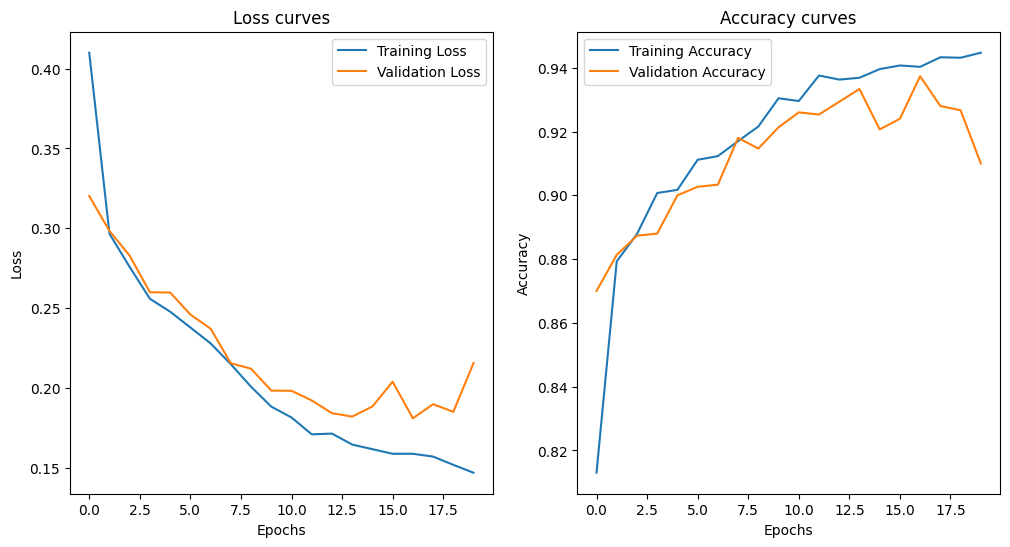

In [25]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curves')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy curves')
plt.legend()

plt.show()


### Making predictions

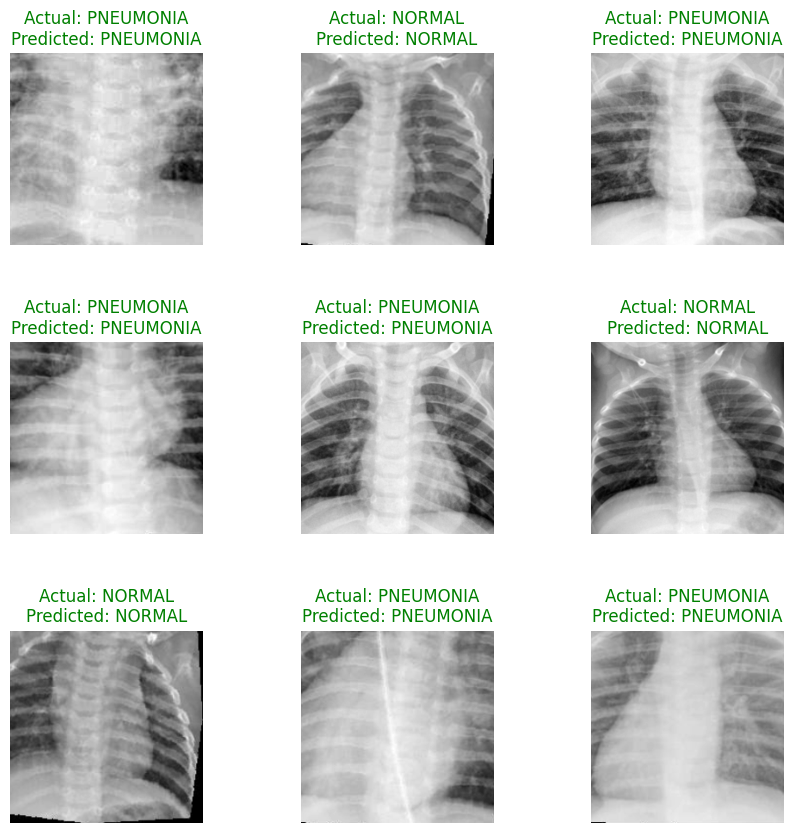

In [26]:
def display_image(image, title, color):
    image = image.numpy().transpose((1, 2, 0))
    image = image.squeeze()
    plt.imshow(image, cmap='gray')
    plt.title(title, color=color)
    plt.axis(False)

num_samples = 9
rows, cols = 3, 3
model.eval()

with torch.inference_mode():
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    sample_count = 0
    
    for images, labels in val_loader:
        if sample_count >= num_samples:
            break
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range(len(images)):
            if sample_count >= num_samples:
                break
            ax = axs[sample_count // cols, sample_count % cols]
            plt.sca(ax) # Set the current axes
            title_color = 'green' if labels[j].item() == predicted[j].item() else 'red'
            display_image(images[j].cpu(), f"Actual: {class_names[labels[j].item()]}\nPredicted: {class_names[predicted[j].item()]}", title_color)
            sample_count += 1

    plt.show()


### Confusion matrix

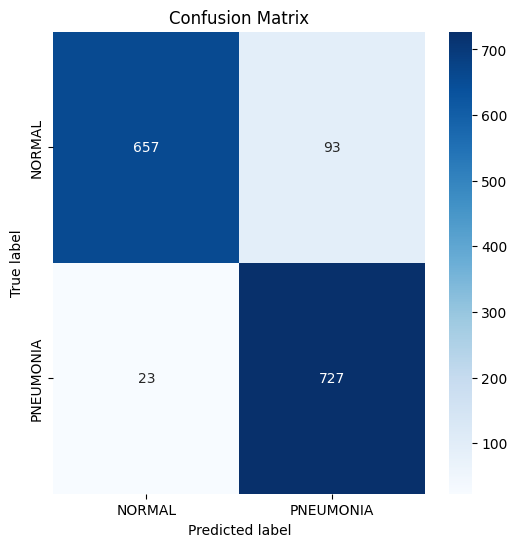

In [27]:
# Get true labels and predicted labels
y_true = []
y_pred = []

model.eval()
with torch.inference_mode():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Evaluation Summary

The evaluation of the model indicates that it performs reasonably well on both training and validation datasets. The loss curves and accuracy curves provide insight into how the model learns and generalizes to unseen data over the training epochs. It is important to monitor these curves to ensure that the model is not overfitting the training data, which would result in poor performance on the validation dataset.

There are several ways to potentially improve the model's accuracy:

1. **Data augmentation:** Increase the variety of training data by applying different transformations, such as rotations, translations, and flips. This can help the model learn more robust features, which could lead to better generalization.
2. **Model architecture:** Experiment with different model architectures, such as deeper or wider networks, to find a more suitable model for the task. Alternatively, consider using pre-trained models and fine-tuning them for your specific task.
3. **Hyperparameter tuning:** Optimize various hyperparameters, such as learning rate, batch size, and weight initialization, to find a better combination that can lead to improved model performance.
4. **Regularization techniques:** Apply techniques like dropout or weight decay to reduce overfitting and improve generalization.
5. **Training for more epochs:** Increase the number of training epochs, which could allow the model to learn more complex features and improve its performance on the task. 

However, be cautious not to overtrain the model, as this may lead to overfitting.
In conclusion, the model's performance can be improved by exploring different techniques and approaches. Carefully monitoring the loss and accuracy curves during training and validation will help identify areas for potential improvement and ensure the model generalizes well to new data.




## Saving and loading data

In [28]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

# Save the model
save_model(model, "my_model.pth")

In [30]:
def load_model(model_class, filename, device='cpu', *args, **kwargs):
    model = model_class(*args, **kwargs)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()
    return model

# Load the model
loaded_model = load_model(PneumoniaClassifier, "my_model.pth", device, 1, 10, 2)